<a href="https://colab.research.google.com/github/HR0262/AI-in-transportation-assignments/blob/main/project/projectcodexgblstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_df = pd.read_csv("training_dataset.csv",sep=";")
train_df

,DP_ID,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW
0,543,"E4S 56,780",20210601,04:00:00,240,48,16,8,4,19.34,10.0
1,539,"E4S 56,160",20210601,04:00:00,240,48,16,8,4,19.64,9.0
2,534,"E4S 56,780",20210601,04:00:00,240,48,16,8,4,23.36,5.0
3,351,"E4S 56,490",20210601,04:00:00,240,48,16,8,4,20.14,7.0
4,353,"E4S 57,055",20210601,04:00:00,240,48,16,8,4,17.70,7.0
...,...,...,...,...,...,...,...,...,...,...,...
1921962,353,"E4S 57,055",20211231,10:00:00,600,120,40,20,10,17.45,11.0
1921963,543,"E4S 56,780",20211231,10:00:00,600,120,40,20,10,18.09,11.0
1921964,153,"E4S 56,490",20211231,10:00:00,600,120,40,20,10,23.53,7.0
1921965,351,"E4S 56,490",20211231,10:00:00,600,120,40,20,10,18.49,9.0


In [3]:
# new dataframe for sum speed and flow
portal_avg_df = train_df.groupby(['PORTAL', 'Date', 'Time'], as_index=False).agg({
    'Interval_1': 'first',  # Keep the first value of the interval column
    'Interval_5': 'first',
    'Interval_15': 'first',
    'Interval_30': 'first',
    'Interval_60': 'first',
    'SPEED_MS_AVG': 'mean',  # Calculate average speed
    'FLOW': 'sum'  # Calculate sum flow
})

# sorting the value to original
portal_avg_df = portal_avg_df.sort_values(by=['Date', 'Time'])

# Save to CSV
# portal_avg_df.to_csv('portal_avg_speed_flow_with_intervals.csv', index=False)

# show data
portal_avg_df

,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW
0,"E4S 55,620",20210601,04:00:00,240,48,16,8,4,22.110000,29.0
74333,"E4S 56,160",20210601,04:00:00,240,48,16,8,4,23.326667,28.0
148548,"E4S 56,490",20210601,04:00:00,240,48,16,8,4,21.460000,24.0
224995,"E4S 56,780",20210601,04:00:00,240,48,16,8,4,20.047500,27.0
301341,"E4S 57,055",20210601,04:00:00,240,48,16,8,4,20.520000,27.0
...,...,...,...,...,...,...,...,...,...,...
301340,"E4S 56,780",20211231,10:00:00,600,120,40,20,10,17.907500,40.0
375372,"E4S 57,055",20211231,10:00:00,600,120,40,20,10,18.993333,42.0
451461,"E4S 57,435",20211231,10:00:00,600,120,40,20,10,21.206667,25.0
527686,"E4S 57,820",20211231,10:00:00,600,120,40,20,10,21.106667,20.0


In [25]:
# Get the unique portal values
portal_ids = portal_avg_df['PORTAL'].unique()

# Create a dictionary to hold the split dataframes
portal_avg_dfs = {}

# Loop through each PORTAL and create a separate dataframe
for portal_id in portal_ids:
    portal_avg_dfs[f'portal_avg_df_{portal_id}'] = portal_avg_df[portal_avg_df['PORTAL'] == portal_id]
print(portal_ids)

['E4S 55,620' 'E4S 56,160' 'E4S 56,490' 'E4S 56,780' 'E4S 57,055'
 'E4S 57,435' 'E4S 57,820' 'E4S 58,140']


In [50]:
from datetime import datetime
# 创建一个空的列表来存储每个portal的向量化数据集
vectorized_portal_datasets = []
nintvals=361
# 首先，找到所有portal中出现的唯一的日期
all_days = set()
for portal in portal_ids:
    df = portal_avg_dfs[f'portal_avg_df_{portal}']
    df_sorted = df.sort_values(["Date", "Interval_1"])
    all_days.update(df_sorted['Date'].unique())
all_days = sorted(all_days)
all_days_formatted = [datetime.strptime(str(day), '%Y%m%d').date() for day in all_days]
print(all_days)

# 循环遍历每个portal
for portal in portal_ids:
    df = portal_avg_dfs[f'portal_avg_df_{portal}']
    df_sorted = df.sort_values(["Date", "Interval_1"])

    # 提取唯一的日期
    days = np.unique(df_sorted['Date'].values)

    # 计算总天数
    ndays = len(days)

    # 按日期分组
    day_subsets_df = df_sorted.groupby(["Date"])

    # 创建一个填满NaN值的矩阵
    vectorized_day_dataset = np.full((len(all_days), nintvals), np.nan)

    # 循环遍历每个唯一的天
    for i, day in enumerate(all_days):
        if day in days:
            df_t = day_subsets_df.get_group(day)

            # 循环遍历当前天的DataFrame的每一行
            for j in range(len(df_t)):
                # 提取"Interval_1"和"FLOW"值，并填充'vectorized_day_dataset'
                interval_index = df_t.iloc[j]["Interval_1"] - 240
                if 0 <= interval_index < nintvals:  # 确保索引有效
                    vectorized_day_dataset[i, interval_index] = df_t.iloc[j]["FLOW"]

    # 将当前portal的向量化数据集添加到列表中
    vectorized_portal_datasets.append(vectorized_day_dataset)

# 将所有向量化数据集合并为一个大的三维数组
final_vectorized_dataset = np.array(vectorized_portal_datasets)

# 打印结果
print(final_vectorized_dataset)
print(final_vectorized_dataset.shape)

[20210601, 20210602, 20210603, 20210604, 20210605, 20210606, 20210607, 20210608, 20210609, 20210610, 20210611, 20210612, 20210613, 20210614, 20210615, 20210616, 20210617, 20210618, 20210619, 20210620, 20210621, 20210622, 20210623, 20210624, 20210625, 20210626, 20210627, 20210628, 20210629, 20210630, 20210701, 20210702, 20210703, 20210704, 20210705, 20210706, 20210707, 20210708, 20210709, 20210710, 20210711, 20210712, 20210713, 20210714, 20210715, 20210716, 20210717, 20210718, 20210719, 20210720, 20210721, 20210722, 20210723, 20210724, 20210725, 20210726, 20210727, 20210728, 20210729, 20210730, 20210731, 20210801, 20210802, 20210803, 20210804, 20210805, 20210806, 20210807, 20210808, 20210809, 20210810, 20210811, 20210812, 20210813, 20210814, 20210815, 20210816, 20210817, 20210818, 20210819, 20210820, 20210821, 20210822, 20210823, 20210824, 20210825, 20210826, 20210827, 20210828, 20210829, 20210830, 20210831, 20210901, 20210902, 20210903, 20210904, 20210905, 20210906, 20210907, 20210908,

<ipython-input-50-5c30635b0216>:35: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_t = day_subsets_df.get_group(day)


[[[29. 26. 38. ... 60. 46. 68.]
  [29. 23. 29. ... 54. 59. 59.]
  [37. 35. 36. ... 57. 40. 53.]
  ...
  [ 1.  6.  3. ... 50. 47. 45.]
  [ 6.  3.  6. ... 42. 46. 62.]
  [ 2.  3.  1. ... 24. 14. 16.]]

 [[28. 33. 42. ... 47. 59. 61.]
  [26. 29. 35. ... 54. 59. 52.]
  [34. 38. 27. ... 45. 49. 51.]
  ...
  [ 3.  4.  4. ... 50. 43. 56.]
  [ 4.  5.  6. ... 38. 54. 57.]
  [ 2.  1.  1. ... 14. 16. 27.]]

 [[24. 38. 43. ... 55. 64. 69.]
  [25. 35. 37. ... 60. 64. 57.]
  [35. 36. 34. ... 50. 55. 58.]
  ...
  [ 4.  6.  2. ... 49. 53. 62.]
  [ 3.  7.  7. ... 48. 58. 56.]
  [ 2.  3.  2. ... 18. 13. 42.]]

 ...

 [[ 4.  3.  5. ... 58. 54. 69.]
  [ 3.  2.  1. ... 58. 57. 66.]
  [ 8.  4.  6. ... 59. 61. 66.]
  ...
  [ 4.  1.  6. ... 49. 39. 44.]
  [ 2.  4.  8. ... 36. 40. 28.]
  [ 1.  3.  4. ... 22. 23. 25.]]

 [[ 4.  3.  7. ... 50. 60. 72.]
  [ 3.  1.  4. ... 60. 57. 60.]
  [ 8.  3.  7. ... 59. 52. 68.]
  ...
  [ 2.  3.  5. ... 48. 49. 30.]
  [ 1.  7.  7. ... 31. 43. 33.]
  [nan  4.  4. ... 18. 24. 2

In [112]:
#提取speed
vectorized_portal_datasets=[]
for portal in portal_ids:
    portal = 'E4S 55,620'
    df = portal_avg_dfs[f'portal_avg_df_{portal}']
    df_sorted = df.sort_values(["Date", "Interval_1"])

    # 提取唯一的日期
    days = np.unique(df_sorted['Date'].values)

    # 计算总天数
    ndays = len(days)

    # 按日期分组
    day_subsets_df = df_sorted.groupby(["Date"])

    # 创建一个填满NaN值的矩阵
    vectorized_day_dataset = np.full((len(all_days), nintvals), np.nan)

    # 循环遍历每个唯一的天
    for i, day in enumerate(all_days):
        if day in days:
            df_t = day_subsets_df.get_group(day)

            # 循环遍历当前天的DataFrame的每一行
            for j in range(len(df_t)):
                # 提取"Interval_1"和"FLOW"值，并填充'vectorized_day_dataset'
                interval_index = df_t.iloc[j]["Interval_1"] - 240
                if 0 <= interval_index < nintvals:  # 确保索引有效
                    vectorized_day_dataset[i, interval_index] = df_t.iloc[j]["SPEED_MS_AVG"]
    # 将当前portal的向量化数据集添加到列表中
    vectorized_portal_datasets.append(vectorized_day_dataset)

# 将所有向量化数据集合并为一个大的三维数组
final_vectorized_dataset_speed = np.array(vectorized_portal_datasets)

# 打印结果
print(final_vectorized_dataset_speed)
print(final_vectorized_dataset_speed.shape)

<ipython-input-112-b7cbc1024417>:23: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_t = day_subsets_df.get_group(day)


[[[22.11       23.53333333 21.83       ... 19.09       17.96
   19.48333333]
  [23.61333333 22.45666667 22.78333333 ... 19.40333333 19.56666667
   19.52666667]
  [23.56666667 22.20666667 23.28       ... 19.89333333 19.85
   20.33666667]
  ...
  [18.6        19.77       19.9        ... 18.89       19.54333333
   19.15333333]
  [23.05       22.23       21.415      ... 20.14333333 19.26666667
   18.53333333]
  [21.4        25.35       20.3        ... 20.84       21.23666667
   22.44      ]]

 [[22.11       23.53333333 21.83       ... 19.09       17.96
   19.48333333]
  [23.61333333 22.45666667 22.78333333 ... 19.40333333 19.56666667
   19.52666667]
  [23.56666667 22.20666667 23.28       ... 19.89333333 19.85
   20.33666667]
  ...
  [18.6        19.77       19.9        ... 18.89       19.54333333
   19.15333333]
  [23.05       22.23       21.415      ... 20.14333333 19.26666667
   18.53333333]
  [21.4        25.35       20.3        ... 20.84       21.23666667
   22.44      ]]

 [[22.11    

In [113]:
vectorized_day_dataset_speed0 = final_vectorized_dataset_speed[0]
vectorized_day_dataset_flow0 = final_vectorized_dataset[0]
print(vectorized_day_dataset_speed0)
print(vectorized_day_dataset_flow0)

[[22.11       23.53333333 21.83       ... 19.09       17.96
  19.48333333]
 [23.61333333 22.45666667 22.78333333 ... 19.40333333 19.56666667
  19.52666667]
 [23.56666667 22.20666667 23.28       ... 19.89333333 19.85
  20.33666667]
 ...
 [18.6        19.77       19.9        ... 18.89       19.54333333
  19.15333333]
 [23.05       22.23       21.415      ... 20.14333333 19.26666667
  18.53333333]
 [21.4        25.35       20.3        ... 20.84       21.23666667
  22.44      ]]
[[29. 26. 38. ... 60. 46. 68.]
 [29. 23. 29. ... 54. 59. 59.]
 [37. 35. 36. ... 57. 40. 53.]
 ...
 [ 1.  6.  3. ... 50. 47. 45.]
 [ 6.  3.  6. ... 42. 46. 62.]
 [ 2.  3.  1. ... 24. 14. 16.]]


(361,)
0.02265902089212209


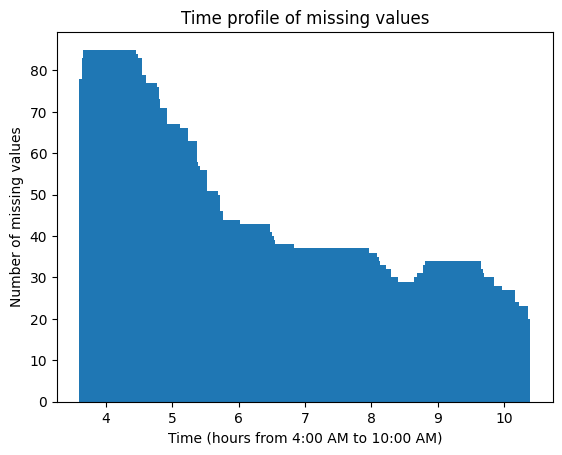

In [62]:
# Calculate the number of missing values per 1-minute interval
nans_per_time_all_portals = np.zeros(361,)

# 循环遍历每个portal
for i in range(8):
    # 计算当前portal的每个时间间隔的缺失值数量
    nans_per_time = np.sum(np.isnan(final_vectorized_dataset[i]), axis=0)
    # 累加到总缺失值数组
    nans_per_time_all_portals += nans_per_time

print(nans_per_time_all_portals.shape)

# Define the number of 1-minute intervals between 4:00 AM and 10:00 AM
nintvals = 361  # 6 hours * 60 minutes = 360 intervals

# Create an array 'x_axis' representing the 1-minute intervals
x_axis = np.arange(0, nintvals, 1, dtype=int)

# Initialize an empty list 'x_axis_hours' to store time values in hours
x_axis_hours = []

# Convert interval indices to hours and append them to 'x_axis_hours'
for i in range(0, len(x_axis)):
    x_axis_hours.append(4 + float(x_axis[i]) / 60)  # Start at 4 AM, and each interval is 1 minute

# Plot the number of missing values over time
fig, ax = plt.subplots()
ax.bar(x_axis_hours, height=nans_per_time_all_portals)
print(sum(nans_per_time_all_portals)/(8*214*361))
# Set labels and title
ax.set_ylabel('Number of missing values')
ax.set_xlabel('Time (hours from 4:00 AM to 10:00 AM)')
ax.set_title('Time profile of missing values')

# Display the plot
plt.show()

In [114]:
final_vectorized_dataset_2d = final_vectorized_dataset.transpose(1, 0, 2).reshape(-1, final_vectorized_dataset.shape[2])
print(final_vectorized_dataset_2d)
print(final_vectorized_dataset_2d.shape)

[[29. 26. 38. ... 60. 46. 68.]
 [28. 33. 42. ... 47. 59. 61.]
 [24. 38. 43. ... 55. 64. 69.]
 ...
 [ 1.  3.  4. ... 22. 23. 25.]
 [nan  4.  4. ... 18. 24. 20.]
 [ 1.  3.  7. ... 23. 19. 20.]]
(1712, 361)


In [116]:
#插值方法一
df = pd.DataFrame(final_vectorized_dataset_2d)

# 假设数据具有每周7天的周期性
period = 7 * 8

# 自定义函数进行周期性插值
def periodic_interpolation(df, period):
    # 对于每一列（代表一个时间间隔）
    for col in df.columns:
        # 遍历每一行
        for i in range(len(df)):
            # 如果当前行有缺失值
            if np.isnan(df[col][i]):
                # 向前找到当前周期中对应的行（例如，如果今天是星期三，我们查看上一个星期三）
                idx_left = (i + period) % len(df)
                # 如果对应的行也有缺失值，继续向后查找直到找到非缺失值
                while np.isnan(df[col][idx_left]) and idx_left>=0:
                    idx_left = (idx_left + period) % len(df)
                # 向后找
                idx_right = (i + period) % len(df)
                while np.isnan(df[col][idx_right]) and idx_right<len(df):
                    idx_right = (idx_right + period) % len(df)
                # 用找到的非缺失值线性填充当前缺失值
                if idx_right>=len(df):
                  df[col][i] = df[col][idx_left]
                elif idx_left<=0:
                  df[col][i] = df[col][idx_right]
                else:
                  df[col][i] = np.mean([df[col][idx_left], df[col][idx_right]])
    return df

# 应用周期性插值
df_interpolated = periodic_interpolation(df, period)


# 将插值后的 DataFrame 转换回 NumPy 数组
final_vectorized_dataset_2d = df_interpolated.to_numpy()

print(final_vectorized_dataset_2d)
print(final_vectorized_dataset_2d.shape)

1712
[[29. 26. 38. ... 60. 46. 68.]
 [28. 33. 42. ... 47. 59. 61.]
 [24. 38. 43. ... 55. 64. 69.]
 ...
 [ 1.  3.  4. ... 22. 23. 25.]
 [ 7.  4.  4. ... 18. 24. 20.]
 [ 1.  3.  7. ... 23. 19. 20.]]
(1712, 361)


In [121]:
df1 = pd.DataFrame(vectorized_day_dataset_speed0)
df2 = pd.DataFrame(vectorized_day_dataset_flow0)
vectorized_day_dataset_speed0_interpolated = periodic_interpolation(df1, 7).to_numpy()
vectorized_day_dataset_flow0_interpolated = periodic_interpolation(df2, 7).to_numpy()
print(vectorized_day_dataset_speed0_interpolated)
print(vectorized_day_dataset_flow0_interpolated)


[[22.11       23.53333333 21.83       ... 19.09       17.96
  19.48333333]
 [23.61333333 22.45666667 22.78333333 ... 19.40333333 19.56666667
  19.52666667]
 [23.56666667 22.20666667 23.28       ... 19.89333333 19.85
  20.33666667]
 ...
 [18.6        19.77       19.9        ... 18.89       19.54333333
  19.15333333]
 [23.05       22.23       21.415      ... 20.14333333 19.26666667
  18.53333333]
 [21.4        25.35       20.3        ... 20.84       21.23666667
  22.44      ]]
[[29. 26. 38. ... 60. 46. 68.]
 [29. 23. 29. ... 54. 59. 59.]
 [37. 35. 36. ... 57. 40. 53.]
 ...
 [ 1.  6.  3. ... 50. 47. 45.]
 [ 6.  3.  6. ... 42. 46. 62.]
 [ 2.  3.  1. ... 24. 14. 16.]]


In [63]:
#插值方法二
from scipy.interpolate import griddata
# 找到非NaN值的索引
rows, cols = np.where(~np.isnan(final_vectorized_dataset_2d))

# 准备插值的点
points = np.array([cols, rows]).T
values = final_vectorized_dataset_2d[~np.isnan(final_vectorized_dataset_2d)]

# 准备要插值的网格点 (这里我们使用所有点)
# 使用 np.meshgrid 生成二维网格点
grid_x, grid_y = np.meshgrid(np.arange(final_vectorized_dataset_2d.shape[1]), np.arange(final_vectorized_dataset_2d.shape[0]))
grid_points = np.array([grid_x.ravel(), grid_y.ravel()]).T

# 进行插值
interpolated_values = griddata(points, values, grid_points, method='linear')

# 将插值结果赋值回原数组
final_vectorized_dataset_2d = interpolated_values.reshape(final_vectorized_dataset_2d.shape)

print(final_vectorized_dataset_2d)
print(final_vectorized_dataset_2d.shape)

[[29. 26. 38. ... 60. 46. 68.]
 [29. 23. 29. ... 54. 59. 59.]
 [37. 35. 36. ... 57. 40. 53.]
 ...
 [ 2.  4.  4. ... 46. 48. 28.]
 [ 5.  4.  9. ... 28. 40. 43.]
 [ 1.  3.  7. ... 23. 19. 20.]]
(1712, 361)


In [57]:
#插值方法三
# Convert the array to a pandas DataFrame to make use of pandas' interpolation function
vectorized_day_df = pd.DataFrame(final_vectorized_dataset_2d)

# Apply linear interpolation to each column (time interval)
# 'axis=1' means interpolation is done across each row (for each day)
vectorized_day_interpolated = vectorized_day_df.interpolate(method='linear', axis=1, limit_direction='both')

# Convert the DataFrame back to a NumPy array if needed
vectorized_day_dataset_interpolated = vectorized_day_interpolated.to_numpy()
vectorized_day_dataset = vectorized_day_dataset_interpolated

# Print the interpolated data
print(vectorized_day_dataset)
print(vectorized_day_dataset.shape)

[[29. 26. 38. ... 60. 46. 68.]
 [29. 23. 29. ... 54. 59. 59.]
 [37. 35. 36. ... 57. 40. 53.]
 ...
 [ 2.  4.  4. ... 46. 48. 28.]
 [ 5.  4.  9. ... 28. 40. 43.]
 [ 1.  3.  7. ... 23. 19. 20.]]
(1712, 361)


In [89]:
nans_per_day = np.sum(np.isnan(final_vectorized_dataset_2d),1)
print('number of days with missing value',np.size(np.where(nans_per_day > 0),1))

number of days with missing value 0


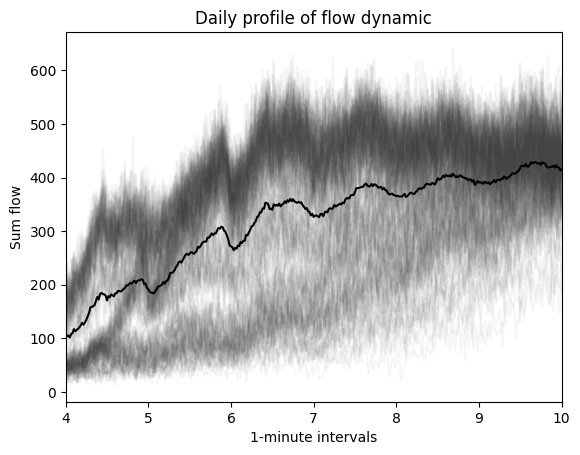

In [91]:
final_vectorized_dataset_2d_daysum = np.zeros(final_vectorized_dataset[0].shape)
for i in range(8):
  final_vectorized_dataset_2d_daysum += final_vectorized_dataset[i]

# Create a new figure and axis object using subplots
fig, ax = plt.subplots()# a convenient way to create a new figure and a set of subplots.
ax.plot(np.array([x_axis_hours,]*ndays).transpose(),final_vectorized_dataset_2d_daysum.transpose(),color='#444444',alpha=0.05)
# Above line plots the dataset with specified color and transparency.
ax.plot(x_axis_hours,np.transpose(np.nanmean(final_vectorized_dataset_2d_daysum,0)),color='black')
# Above line plots the average of the dataset in black color.

ax.set_ylabel('Sum flow')
ax.set_xlabel('1-minute intervals')
plt.xlim(4,10)
ax.set_title('Daily profile of flow dynamic')

plt.show()

In [92]:
import datetime

# Create an array 'day_of_week' to store the day of the week for each unique date
day_of_week = np.zeros((ndays))

# Loop through each unique date
for i in range(0, ndays):
    # Parse the current date from a string to a datetime object
    day_dt = datetime.datetime.strptime(str(days[i]), '%Y%m%d')

    # Get the day of the week (1 for Monday, 2 for Tuesday, ..., 7 for Sunday)
    day_of_week[i] = day_dt.isoweekday()

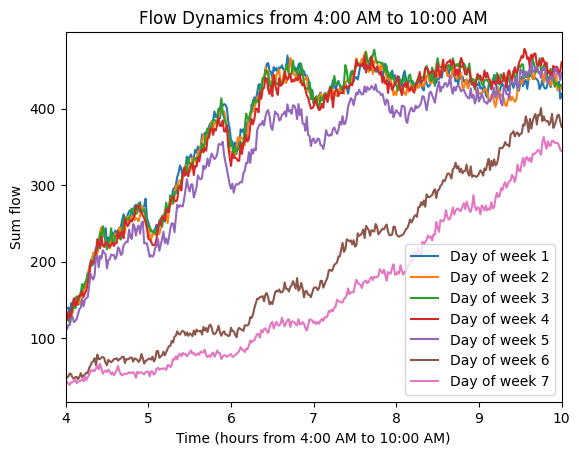

In [94]:
# Define the number of 1-minute intervals between 4:00 AM and 10:00 AM
nintvals = 361  # 6 hours * 60 minutes + 1 extra interval = 361 intervals

# Create an array 'x_axis_hours' representing time in hours from 4:00 AM to 10:00 AM
# Use linspace to generate exactly 361 time points between 4 and 10
x_axis_hours = np.linspace(4, 10, nintvals)

# Create a new figure and axis object using subplots
fig, ax = plt.subplots()

# Iterate through each day of the week (from 1 to 7)
for i in range(1, 8):
    # Find the indices of days that correspond to the current day of the week
    day_of_week_index_t = np.where(day_of_week == i)

    # Calculate the number of days that match the current day of the week
    ndays_t = np.size(day_of_week_index_t[0])

    # Plot the average flow for the current day of the week
    ax.plot(x_axis_hours,  # Plot using the full 361 intervals
            np.nanmean(final_vectorized_dataset_2d_daysum[day_of_week_index_t[0], :nintvals].transpose(), 1),
            label='Day of week ' + str(i))

# Set the y-axis label
ax.set_ylabel('Sum flow')

# Set the x-axis label
ax.set_xlabel('Time (hours from 4:00 AM to 10:00 AM)')

# Set the x-axis limits to be between 4 and 10
plt.xlim(4, 10)

# Set the title of the plot
ax.set_title('Flow Dynamics from 4:00 AM to 10:00 AM')

# Add a legend indicating the day of the week
ax.legend()

# Display the plot
plt.show()

In [ ]:
from dateutil.relativedelta import relativedelta
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib import colors

def assign_colors(n_clusters, days, assigments):

    days_colors = []
    color_to_cluster = []
    style_to_cluster = []
    weekend_colors = ['#67001f','#d6604d','#fdae61','#f46d43','#d53e4f','#9e0142','#f768a1','#f1c232']#,'#fe9929','#cc4c02','#e31a1c','#737373','#bdbdbd','#252525','#bcbddc']
#    weekend_school_colors = ['#c2a5cf','#f1b6da','#8e0152','#c51b7d','#de77ae','#ae017e','#fcc5c0','#e31a1c','#737373','#bdbdbd']
#    bank_holidays_colors = ['#543005','#dfc27d','#bf812d','#8c510a']
    mixed_colors = ['#4d4d4d','#35978f','#bababa','#878787']
    weekday_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#cab2d6','#6a3d9a','#b15928','#8dd3c7','#bebada','#fb8072','#b3de69','#bc80bd','#fccde5','#ccebc5','#35978f','#80cdc1']

    cluster_id_weekdays_share = []
    cluster_id_weekend_share = []
    cluster_id_all_days = []

    for i in range(0,n_clusters):
        color_to_cluster.append(None)
        style_to_cluster.append(None)
        cluster_id_weekdays_share.append(0)
        cluster_id_weekend_share.append(0)
        cluster_id_all_days.append(0)

    for i in range(0,len(days)):
        #print(i,assigments[i],len(assigments),len(cluster_id_all_days))
        if assigments[i] is not None:
            cluster_id_all_days[assigments[i]] += 1
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')

            if int(pomT.weekday()) < 5:
                cluster_id_weekdays_share[assigments[i]] += 1
            else:
                cluster_id_weekend_share[assigments[i]] += 1

    print('cluster_id_weekdays_share',cluster_id_weekdays_share)
    print('cluster_id_weekend_share',cluster_id_weekend_share)
    for i in range(0,len(days)):
        if assigments[i] is not None:
            cluster_idx = assigments[i]
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
            if color_to_cluster[assigments[i]] is None:
                if cluster_id_weekend_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekend_colors.pop()
                        style_to_cluster[assigments[i]] = ':'
                elif cluster_id_weekdays_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekday_colors.pop(0)
                        style_to_cluster[assigments[i]] = '-'
                else:
                    color_to_cluster[assigments[i]] = mixed_colors.pop()
                    style_to_cluster[assigments[i]] = ':'

            days_colors.append(color_to_cluster[assigments[i]])
        else:
            days_colors.append(None)

    return days_colors,color_to_cluster,style_to_cluster


def calmap(ax, year, data, days, assigments, n_clusters,days_colors,color_to_cluster,
           limit_graphics=False):

    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders

    xticks, labels = [], []
    start = datetime.datetime(year,1,1).weekday()

    for month in range(1,13):

        first = datetime.datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]

        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",

                       linewidth=1, zorder=20, clip_on=False)

        ax.add_artist(poly)

    line = Line2D([0,53],[5,5],linewidth=1, zorder = 20,color="black",linestyle='dashed')
    ax.add_artist(line)

    if not limit_graphics:
        ax.set_xticks(xticks)
        ax.set_xticklabels(labels)
        ax.set_yticks(0.5 + np.arange(7))
        ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
        ax.set_title("{}".format(year), weight="semibold")
    else:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False)

    # Clearing first and last day from the data
    valid = datetime.datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime.datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    for i in range(0,len(days)):
        if '-' in str(days[i]):
            pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
        else:
            pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
        week_number = int(pomT.strftime("%W"))
        day_of_week = int(pomT.weekday())
        data[day_of_week,week_number] = assigments[i]


    act_date = datetime.datetime(year,1,1)
    while (act_date.year == year):

        week_number = int(act_date.strftime("%W"))
        day_of_week = int(act_date.weekday())
        doy_id = act_date.timetuple().tm_yday
        if doy_id<5 and week_number > 53:
            week_number = 0

        act_date = act_date + datetime.timedelta(days=1)

    #pomT = datetime.datetime.strptime('2017-01-01','%Y-%m-%d')
    #week_number = int(pomT.strftime("%V"))
    #day_of_week = int(pomT.weekday())
    #print(week_number,day_of_week)
    #doy_id = pomT.timetuple().tm_yday
    #if doy_id<5 and week_number > 0:
    #    week_number = 0
    #data[day_of_week,week_number] = len(clusters)+10

    # Showing data
    cmap = plt.cm.spring  # Can be any colormap that you want after the cm
    cmap.set_bad(color='white')

    #ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=0, vmax=len(clusters)+10,
    #          cmap=cmap, origin="lower", alpha=.75)

    cmap = colors.ListedColormap(color_to_cluster)
    bounds=[-0.1]
    step = 1
    for i in range(0,n_clusters):
        bounds.append(i-0.1+step)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    #print(color_to_cluster)
   #print(bounds)
    #print(norm)

    #print(color_to_cluster)
    #print(bounds)
    #print(cmap)
    #exit(0)

    ax.imshow(data, extent=[0,53,0,7], zorder=10, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)

def make_calendar_visualization_figure(days,assigments,n_clusters,years,days_colors,color_to_cluster,
                                       save_figure: str = None, show_figure:bool = True, limit_graphics = False):

    fig = plt.figure(figsize=(8,1.5*len(years)), dpi=100)
    X = np.linspace(-1,1, 53*7)

    for i, obj in enumerate(years):

        pom_s = str(len(years))+'1'+str(i+1)
        print(pom_s)

        ax = plt.subplot(int(pom_s), xlim=[0, 53], ylim=[0, 7], frameon=False, aspect=1)
        I = 1.2 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
        I = I.reshape(53,7).T
        I.fill(np.nan)
        calmap(ax, int(obj), I.reshape(53,7).T, days, assigments, n_clusters,days_colors,color_to_cluster, limit_graphics)

    #   ax = plt.subplot(212, xlim=[0,53], ylim=[0,7], frameon=False, aspect=1)
    #  I = 1.1 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
    #   calmap(ax, 2018, I.reshape(53,7).T)

    #ax = plt.subplot(313, xlim=[0,53], ylim=[0,7], frameon=False, aspect=1)
    #I = 1.0 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
    #calmap(ax, 2019, I.reshape(53,7).T)
    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()


def make_figure_centroids(x,y,color_to_cluster,style_to_cluster,cluster_ids,minY = None,maxY = None,
                          save_figure: str = None, show_figure:bool = True):

    #print(color_to_cluster)
    fig = plt.figure(figsize=(8,3))
    ax = fig.add_subplot(111)
    for i in range(0,len(x)):
        #print(i,color_to_cluster[i],style_to_cluster[i])
        #print(y[i])
        ax.plot(x[i],y[i],style_to_cluster[i], color=color_to_cluster[i], label=str(cluster_ids[i]))
    ax.set_xlabel('Time of day')
    ax.set_ylabel('Flow')
    if minY is not None and maxY is not None:
        ax.set_ylim([minY, maxY])
    plt.legend()

    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

#clusters = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(vectorized_day_dataset)

In [ ]:
n_clusters = 4
clusters = None
#print(np.where(nans_per_day > 0)[0])
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
days_not_nans = days[np.where(nans_per_day == 0)[0]]

# BELOW lines enables you to comment in and out clustering method you want to use note that GMM have different ouput and thus labels are extracted differently
clusters = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
#clusters = AgglomerativeClustering(n_clusters=n_clusters,metric='euclidean', linkage='ward').fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
#clusters = DBSCAN(eps=500, min_samples = 2).fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

if clusters is not None:
  cluster_labels = clusters.labels_

#cluster_labels = GaussianMixture(n_components=n_clusters).fit(vectorized_day_dataset_no_nans).predict(vectorized_day_dataset_no_nans) #check the parameters at  https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_init.html#sphx-glr-auto-examples-mixture-plot-gmm-init-py


print(cluster_labels)


[1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 3 0 1 1 1 1 1 0 0 3 1 0
 1 2 0 0 2 2 2 2 2 0 0 2 2 2 2 2 0 0 2 2 2 2 0 0 0 2 2 2 2 0 0 1 1 1 1 2 0
 0 1 1 1 1 1 0 3 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1
 1 1 1 0 0 1 1 1 1 1 0 2 0 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1
 0 3 2 2 0 2 2 0 3 2 2 2 2 2 0 3 2 2 2 2 2 0 3 2 2 2 2 2 0 3 2 2 2 2 2 3 3
 2 2 2 2 2 3 3 2 2 2 2 2 3 3 2 2 2 0 3 3 3 0 0 0 0 3]


cluster_id_weekdays_share [11, 81, 58, 3]
cluster_id_weekend_share [43, 0, 0, 15]
111


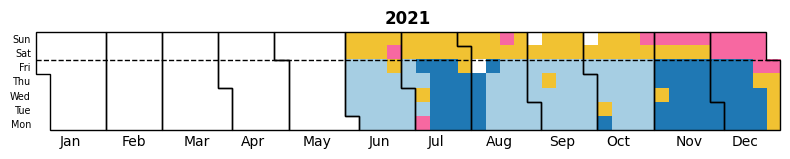

In [ ]:
# Calculate the number of clusters by finding unique values in 'cluster_labels'
n_clusters_t = len(np.unique(cluster_labels))

# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
# The function 'assign_colors' is used to determine colors and styles for visualization.

# Create a calendar visualization figure
make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)
# This function 'make_calendar_visualization_figure' is used to generate a visualization based on the provided data and parameters.
# 'days_not_nans' are the days, 'cluster_labels' are the cluster labels, 'n_clusters_t' is the number of clusters,
# '[2021]' represents the year, 'days_colors' represent the assigned colors for each day, 'color_to_cluster' maps colors to clusters,
# and 'save_figure' is an optional parameter to save the generated figure (can be None if not saving).

Visualising different culstering classes

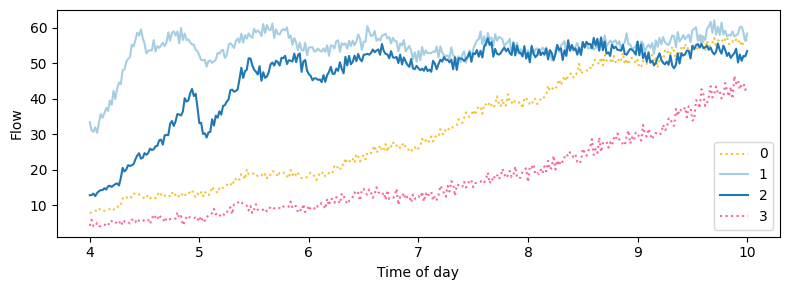

In [ ]:
# Initialize empty lists to store centroid data
centroids_xx = []  # x-axis values for centroids
centroids_yy_daytypes = []  # y-axis values for centroids, grouped by day types
cluster_ids = []  # Cluster IDs

# Iterate through each cluster
for i in range(0, n_clusters_t):
    # Store the x-axis values for centroids (hours of the day)
    centroids_xx.append(x_axis_hours)

    # Calculate the y-axis values for centroids (average flow for each 5-minute interval)
    centroid_yy = list(np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).transpose())
    centroids_yy_daytypes.append(centroid_yy)

    # Store the cluster ID
    cluster_ids.append(i)

# Generate a figure displaying the centroids
make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)
# The function 'make_figure_centroids' is used to create a visualization of the centroids,
# with the provided data and parameters.

时间序列进行预测----xgboost prediction

分离每个聚类的数据，分为类1234，input是30分钟前的30个数据，output是下一分钟的数据，将新预测作为已知数据，逐步预测15分钟的值


In [123]:
# print(final_vectorized_dataset_2d)  #not yet take the clustering into consideration
# print(final_vectorized_dataset_2d.shape)
print(vectorized_day_dataset_speed0_interpolated)
print(vectorized_day_dataset_flow0_interpolated)

[[22.11       23.53333333 21.83       ... 19.09       17.96
  19.48333333]
 [23.61333333 22.45666667 22.78333333 ... 19.40333333 19.56666667
  19.52666667]
 [23.56666667 22.20666667 23.28       ... 19.89333333 19.85
  20.33666667]
 ...
 [18.6        19.77       19.9        ... 18.89       19.54333333
  19.15333333]
 [23.05       22.23       21.415      ... 20.14333333 19.26666667
  18.53333333]
 [21.4        25.35       20.3        ... 20.84       21.23666667
  22.44      ]]
[[29. 26. 38. ... 60. 46. 68.]
 [29. 23. 29. ... 54. 59. 59.]
 [37. 35. 36. ... 57. 40. 53.]
 ...
 [ 1.  6.  3. ... 50. 47. 45.]
 [ 6.  3.  6. ... 42. 46. 62.]
 [ 2.  3.  1. ... 24. 14. 16.]]


需要把数据分割成x-30个值，y-下一分钟的值 （可以考虑用昨天的值预测今天的值）

记得划分为训练集验证集



将数组分为x和y，x为30输入，y为一分钟预测

In [146]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

def datadivide(arr, cluster_labels = None, lag_size = 30, weekend = False, startday = 0, time = 0):
  print(arr.shape)
  rows, columns = arr.shape

  x = []
  y = []

  # Number of input data
  lag_size = 30

  # encoder = OneHotEncoder()
  # one_hot_labels = encoder.fit_transform(cluster_labels.reshape(-1, 1))
  # one_hot_labels = one_hot_labels.toarray()

  # 遍历数组，除了最后 lag_size 个元素
  for i in range(rows):
    for j in range(columns - lag_size):
      # if cluster_labels[i] == 0:
        # 对于每个时间步长，创建一个包含前 lag_size 个元素的 x 特征数组
        x_features = arr[i][j:j+lag_size].flatten()
        # y 是当前时间步长的数据
        y_value = np.mean(arr[i][j+lag_size:j+lag_size+15])
        # 加入聚类结果
        if cluster_labels:
          x_features = np.append(x_features, cluster_labels[i])
        # 加入当前时间
        if time:
          x_features = np.append(x_features, j//time)
        # x_features = np.append(x_features, i%8)
        # 加入当天的flow_aver
        # flow_aver = np.average(vectorized_day_dataset[i])
        # x_features = np.append(x_features, flow_aver)
        if weekend:
          if i%7+startday ==6 or i%7+startday ==7:
            x_features = np.append(x_features, 1)
          else:
            x_features = np.append(x_features, 0)


        # 将它们添加到相应的列表中
        x.append(x_features)
        y.append(y_value)

  # translate it to NumPy array
  x = np.array(x)
  y = np.array(y)

  return x, y

In [176]:
x1, y1 = datadivide(vectorized_day_dataset_speed0_interpolated)
x2, y2 = datadivide(vectorized_day_dataset_flow0_interpolated, time=5, weekend = False, startday = 2)
x = np.concatenate((x1, x2), axis=1)
y = y2
x = np.concatenate((x1, x2), axis=1)
print(x.shape)
print(y.shape)

(214, 361)
(214, 361)
(70834, 61)
(70834,)


pca

In [177]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  #standardize it
x_scaled = scaler.fit_transform(x)


# # 分离出需要进行PCA降维的特征和不需要降维的特征
# features_to_reduce = x[:, :30]  # 前30个特征
# features_to_keep = x[:, 30:]    # 后2个特征

# pca = PCA(n_components=30)  # Adjust the number of components (dimensions) as needed
# features_reduced = pca.fit_transform(x_scaled)
# print(features_reduced.shape)

# explained_variance = pca.explained_variance_ratio_
# print(f'Explained Variance Ratio: {explained_variance}')
# print(f"Sum of the explained variance: {sum(explained_variance)}")

# # 将降维后的特征和原始特征拼接起来
# data_transformed = np.hstack((features_reduced, features_to_keep))
# print(data_transformed.shape)

data_transformed = x_scaled

tran test split ----test size 0.2

Can't be divided randomly because the output will be contained within the inputs

In [215]:
test_size = 0.2

x_train_pca = data_transformed[:int(len(x)*(1-test_size))]
x_test_pca = data_transformed[int(len(x)*(1-test_size)):]
y_train = y[:int(len(y)*(1-test_size))]
y_test = y[int(len(y)*(1-test_size)):]

print(x_train_pca.shape)
print(x_test_pca.shape)
print(y_train.shape)
print(y_test.shape)


(56667, 61)
(14167, 61)
(56667,)
(14167,)


In [179]:
from mmap import MAP_EXECUTABLE
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


# # 定义参数分布
# param_distribution = {
#     'n_estimators': randint(100, 500),
#     'learning_rate': uniform(0.01, 0.2),
#     'max_depth': randint(3, 10),
#     'min_child_weight': randint(1, 10),
# }

# # 创建XGBRegressor模型
# xgb_reg = XGBRegressor()

# # 创建RandomizedSearchCV对象
# random_search = RandomizedSearchCV(
#     estimator=xgb_reg,
#     param_distributions=param_distribution,
#     n_iter=100,  # 可以根据需要调整迭代次数
#     scoring='neg_mean_squared_error',
#     cv=3,
#     random_state=42
# )

# # 执行随机搜索
# random_search.fit(x_train_pca, y_train)

# # 输出最佳参数
# print("Best parameters found: ", random_search.best_params_)

# # 输出最佳模型得分
# print("Best model score: ", random_search.best_score_)

# different models
# model = LinearRegression()
model = XGBRegressor()
# model = RandomForestRegressor()
# model = SVR()
# model = DecisionTreeRegressor()
# model = XGBRegressor(learning_rate=0.026170665266543047, max_depth=5, min_child_weight=1, n_estimators=354)

model.fit(x_train_pca, y_train)
y_pred = model.predict(x_test_pca)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 2.9986698921888206
Mean Absolute Percentage Error: 0.10580051967252017
Mean Squared Error: 17.169804950660737
R-squared: 0.9435934265711403


In [218]:
#lstm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# 1. 数据准备 - 滑动窗口生成特征
def create_lstm_data(data, lag_size):
    x = []
    y = []
    rows, columns = data.shape
    for i in range(rows):
        for j in range(columns - lag_size):
            x_features = data[i][j:j+lag_size]
            # 把簇标签附加到特征中
            # x_features_with_cluster = np.append(x_features, cluster_labels[i])
            y_value = data[i][j+lag_size]
            x.append(x_features)
            y.append(y_value)
    return np.array(x), np.array(y)

# 假设 `vectorized_day_dataset` 是你的完整时间序列数据矩阵
data1 = vectorized_day_dataset_speed0_interpolated
data2 = vectorized_day_dataset_flow0_interpolated

# 3. 生成带有聚类标签的时间序列特征数据
lag_size = 30  # 滑动窗口的大小，使用前 30 个时间步预测下一个时间步
x1, y1 = create_lstm_data(data1, lag_size)
x2, y2 = create_lstm_data(data2, lag_size)
y = y2

# 4. 数据划分为训练集和测试集
test_size = 0.2
split_index = int(len(x) * (1 - test_size))
# x_train, x_test = x[:split_index], x[split_index:]
# y_train, y_test = y[:split_index], y[split_index:]
x1_train, x1_test = x1[:split_index], x1[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
x2_train, x2_test = x2[:split_index], x2[split_index:]


# 5. 数据标准化
scaler1 = StandardScaler()
scaler2 = StandardScaler()
# x_train_scaled = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
# x_test_scaled = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

x1_train_scaled = scaler1.fit_transform(x1_train.reshape(-1, x1_train.shape[-1])).reshape(x1_train.shape)
x1_test_scaled = scaler1.transform(x1_test.reshape(-1, x1_test.shape[-1])).reshape(x1_test.shape)
x2_train_scaled = scaler2.fit_transform(x2_train.reshape(-1, x2_train.shape[-1])).reshape(x2_train.shape)
x2_test_scaled = scaler2.transform(x2_test.reshape(-1, x2_test.shape[-1])).reshape(x2_test.shape)

# x1_train_scaled = x1_train
# x2_train_scaled = x2_train

# 6. 将数据调整为适合 LSTM 的三维形式 (样本数, 时间步长 + 簇标签, 特征数)
# x_train_scaled = x_train_scaled.reshape((x_train_scaled.shape[0], lag_size, 2))  # 加上簇标签后时间步长加1
# x_test_scaled = x_test_scaled.reshape((x_test_scaled.shape[0], lag_size, 2))
x_train_scaled = np.stack((x1_train_scaled, x2_train_scaled), axis=-1)
x_test_scaled = np.stack((x1_test_scaled, x2_test_scaled), axis=-1)
# print(x_train_scaled)
# print(x_train_scaled.shape)
# print(y)




In [219]:
# 7. 创建 LSTM 模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(lag_size, 2)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 8. 训练模型
model.fit(x_train_scaled, y_train, epochs=20, batch_size=32, verbose=1)

# 9. 预测并评估模型
y_pred = model.predict(x_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1771/1771 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - loss: 4771.4263
Epoch 2/20
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 73.9881
Epoch 3/20
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 71.8680
Epoch 4/20
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 71.8603
Epoch 5/20
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 72.3792
Epoch 6/20
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - loss: 71.4195
Epoch 7/20
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - loss: 70.2611
Epoch 8/20
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 70.5684
Epoch 9/20
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - loss: 70.3972
Epoch 10/20
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 69.8662
Epoch 11/20
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 69.9374
Epoch 12/20
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 68.7828
Epoch 13/20
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 68.6189
Epoch 14/20
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 67.9